# PREPARATION

In [1]:
from template_csp import managetemp as mte
import numpy as np
from template_csp.distances import  levensthein_distance, perm_distance
import json

hyperparameters = {
    ## GENERAL HYPERPARAMETERS 
    "comp" : 1,
    "job_id": 0,
    ## HYPERPARAMETERS FOR THE INITIAL SET
    "n_template" : 30,


    ## HYPERPARAMETERS FOR THE FINAL SET
    "n_pairs": 30,
    "weight_occurrence" : 1,
    "weight_sg" : 0.001,
    "weight_formation_entalphy" : 1,
    "n_final_templates" : 10,
    
}

ntemp_initial_set = 20

with open(f'ENTHALPY/A{hyperparameters["comp"]}B.json') as json_file:
    data = json.load(json_file)

test_elements=['Be', 'B', 'N', 'Mg', 'O', 'Li', 'C', 'Na', 'Si', 'S', 'Cl', 'F', 'P', 'H', 'Al']

# initial_set = mte.InitialSet(test_elements, hyperparameters, f'RunOneTempPerPair/{hyperparameters["comp"]}/{ntemp_initial_set}/TemplateSet_0')
# final_set = mte.FinalSet(initial_set, test_elements, hyperparameters, f'RunOneTempPerPair/{hyperparameters["comp"]}/{ntemp_initial_set}/PairSet_0')
initial_set = mte.generate_initial_set(hyperparameters, test_elements)
final_set = mte.generate_final_set(initial_set, hyperparameters, test_elements)


reduced_set = final_set.reduced_set()
n_temp_final = final_set.num_final_template

initial_set.recap()
final_set.recap()

pmatrix = {}
pairs_studied = np.array([])

if hyperparameters["comp"] == 1:

    for i in range(len(test_elements)):
        for j in range(i+1,len(test_elements)):
            pair = [test_elements[i],test_elements[j]]
            pair.sort()
            pair = ''.join(pair)
            pvec = np.zeros((2, len(reduced_set)))

            for idx, template in enumerate(reduced_set):
                pvec[0,idx] = float(data[pair][template])
                pvec[1,idx] = idx
            
            sorted_idx = np.argsort(pvec[0])
            pvec[0] = pvec[0][sorted_idx]
            pvec[1] = pvec[1][sorted_idx]

            pmatrix[pair] = pvec
            pairs_studied = np.append(pairs_studied, pair)

else:

    for i in range(len(test_elements)):
        for j in range(len(test_elements)):
            if i == j:
                continue

            pair = [test_elements[i],test_elements[j]]
            pair = ''.join(pair)
            pvec = np.zeros((2, len(reduced_set)))

            for idx, template in enumerate(reduced_set):
                pvec[0,idx] = float(data[pair][template])
                pvec[1,idx] = idx
            
            sorted_idx = np.argsort(pvec[0])
            pvec[0] = pvec[0][sorted_idx]
            pvec[1] = pvec[1][sorted_idx]

            pmatrix[pair] = pvec
            pairs_studied = np.append(pairs_studied, pair)

lev_dist_matrix = np.zeros((len(pairs_studied), len(pairs_studied)))

## Create the distance matrix between the pair ranking vectors constructed using all the templates in the final set

for row, pair1 in enumerate(pairs_studied):
    for col, pair2 in enumerate(pairs_studied):
        if row == col:
            lev_dist_matrix[row,col] = 0
        else:
            lev_dist_matrix[row,col] = levensthein_distance(pmatrix[pair1], pmatrix[pair2]) 


[0.05037483 1.         0.0618157  0.06732872 0.06559418 0.33727655
 0.01889681 0.03420506 0.00554544 0.06562304 0.3533382  0.06628024
 0.05091352 0.04941875 0.06532397 0.04608426 0.03740583 0.00986789
 0.00737362 0.00596163 0.01401102 0.66586596 0.04741832 0.01057666
 0.04116818 0.06472428 0.99456749 0.02560239 0.42694252 0.02277439]
[0.08630301 0.42464507 0.42329784 0.69203923 0.68594533 0.38492392
 0.37197328 1.         0.08563834 0.68596195 0.37606004 0.68915049
 0.08603601 0.0848324  0.68596827 0.37955312 0.10029633 0.15537529
 0.08590349 0.13150982 0.16681859 0.54797502 0.15371343 0.0940203
 0.10722543 0.39992989 0.34948827 0.37688109 0.27808815 0.36295555]
[ 0.62737608 -2.67402695 -3.03746601 -0.75948435 -0.7562694  -1.90109107
 -2.01203678  1.         -2.63224583 -0.75583721 -1.86165884 -0.75375449
  0.62701451  0.71344515 -0.78553517 -2.25007259 -3.22157996 -3.25053744
 -2.64208986 -2.97924316 -3.49234746 -3.23764676 -0.76947672 -2.63689389
 -3.32083821 -3.03093544 -2.70012761 

# DENDOGRAM

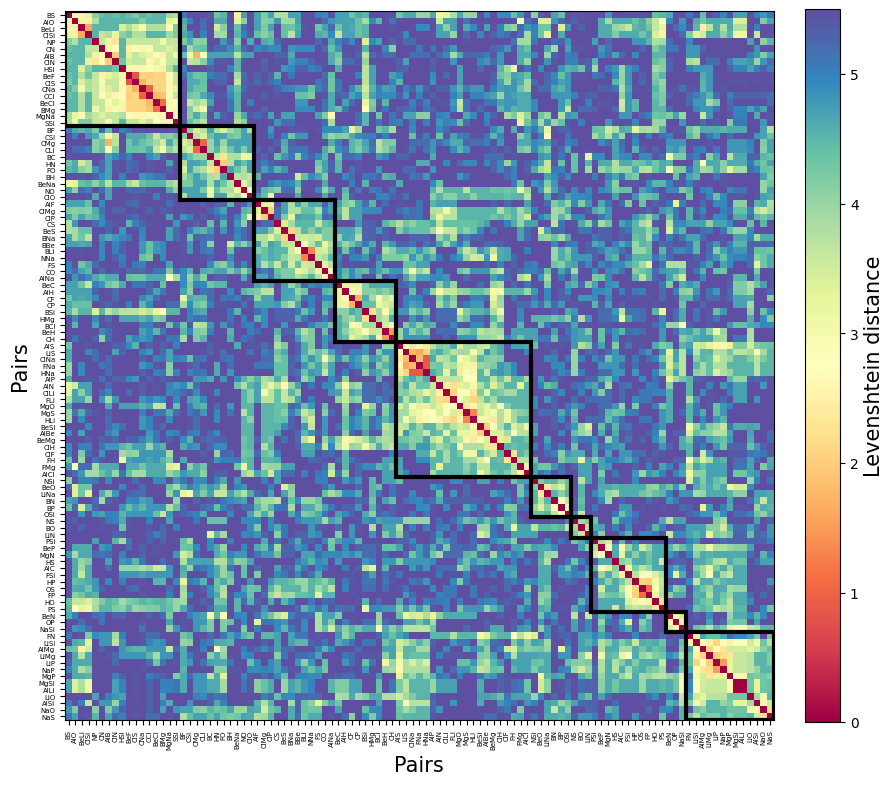

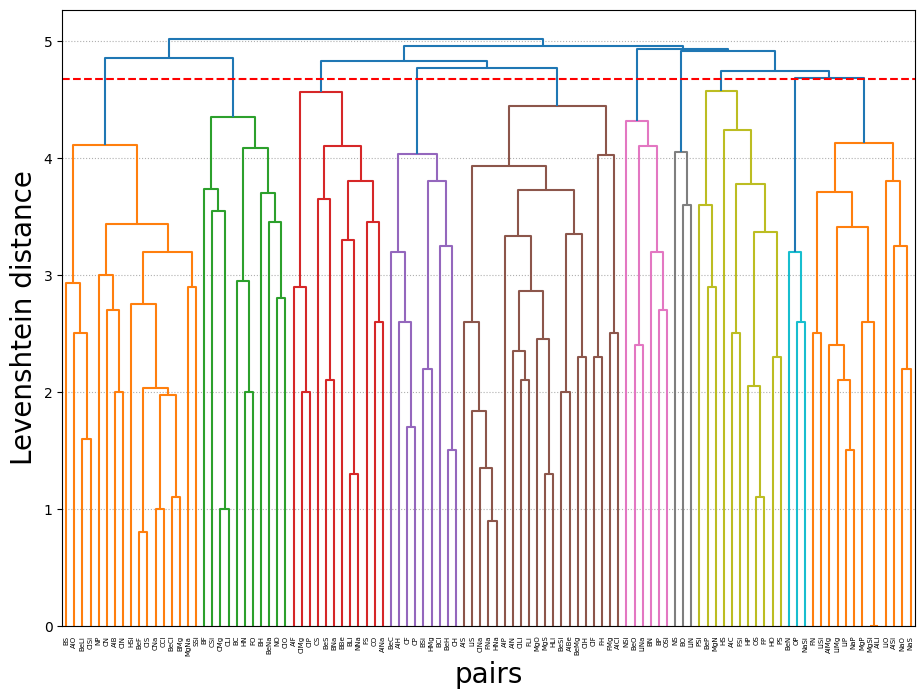

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig1, ax1 = plt.subplots(1, 1, figsize=(11, 8))

condensed_dist_matrix = squareform(lev_dist_matrix)
Z = linkage(condensed_dist_matrix, method='average')

num_clusters = 10
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')
threshold = Z[-(num_clusters-1), 2]

dendro = dendrogram(Z ,labels = pairs_studied, leaf_rotation=90, leaf_font_size=5, ax=ax1, color_threshold=threshold)

sorted_idx = dendro['leaves']

new = lev_dist_matrix[sorted_idx, :][:, sorted_idx]
cluster_labels_sorted = cluster_labels[sorted_idx]

im = ax.imshow(new, cmap='Spectral') #or Spectral

pairs_in_clusters = []
cluster_distances = {}

unique_clusters = np.unique(cluster_labels_sorted)

for cluster in unique_clusters:
    # Trova gli indici che appartengono a questo cluster
    cluster_indices = np.where(cluster_labels_sorted == cluster)[0]

    pairwise_indices = [(i, j) for i in cluster_indices for j in cluster_indices if i < j]
    # Calcola la distanza media per il cluster
    distances = [new[i, j] for i, j in pairwise_indices]
    mean_distance = np.mean(distances) if distances else 0  # Evita errori con cluster singoli
    cluster_distances[cluster] = mean_distance


    if len(cluster_indices) > 0:
        # Trova il primo e l'ultimo elemento del cluster per i bordi
        start, end = cluster_indices[0], cluster_indices[-1]
        cluster_size = end - start + 1
        pairs_in_clusters.append(np.array(pairs_studied)[sorted_idx][start:end+1])

        # Aggiungi un rettangolo per evidenziare il cluster con un piccolo offset
        rect = patches.Rectangle((start - 0.5, start - 0.5), cluster_size, cluster_size,
                                 linewidth=3, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

# Imposta i tick e mostra la figura
ax.set_xticks(np.arange(len(pairs_studied)))
ax.set_yticks(np.arange(len(pairs_studied)))
ax.set_xticklabels(np.array(pairs_studied)[sorted_idx], fontsize=5, rotation=90)
ax.set_yticklabels(np.array(pairs_studied)[sorted_idx], fontsize=5)  
ax.set_xlabel('Pairs', fontsize=15)
ax.set_ylabel('Pairs', fontsize=15)

cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label='Levenshtein distance')
cbar.ax.yaxis.label.set_size(15)
cbar.ax.tick_params(labelsize=10)
# cbar.ax.yaxis.set_label_coords(+2.5, 0.5)

ax1.axhline(y=threshold-0.005, color='r', linestyle='--')
ax1.set_ylabel('Levenshtein distance', fontsize=20)
ax1.set_xlabel('pairs', fontsize=20)
# ax1.xaxis.set_label_coords(0.5, -0.18)
# ax1.yaxis.set_label_coords(-0.07, 0.5)
# yticks = np.linspace(0, 0.5, 5)   
# yticks = np.round(yticks, decimals=1)
# ax1.set_yticks(yticks)
# ax1.set_yticklabels(yticks, fontsize=10)
ax1.grid(True, ls=':', axis='y')
plt.show()
fig.savefig('MatrixHeatmap.png', bbox_inches='tight')



# PIE CHART

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
total_hist = {}
hist = {}
len_cluster = []
for idx_cluster, cluster in enumerate(pairs_in_clusters):
    if len(cluster) == 1:
        continue
    hist[f'{idx_cluster}'] = {}
    len_cluster.append(len(cluster))
    for i in cluster:
        sg = reduced_set[int(pmatrix[i][1][0])]

        if sg not in hist[f'{idx_cluster}'].keys():
            hist[f'{idx_cluster}'][sg] = 1/len(cluster)
        else:
            hist[f'{idx_cluster}'][sg] +=1/len(cluster)
            
        if sg not in total_hist.keys():
            total_hist[sg] = 1
        else:
            total_hist[sg] +=1
            
colormap = {}
for idx, template in enumerate(total_hist.keys()):
    colormap[f'{template}'] = cm.Set2(idx/len(total_hist.keys()))


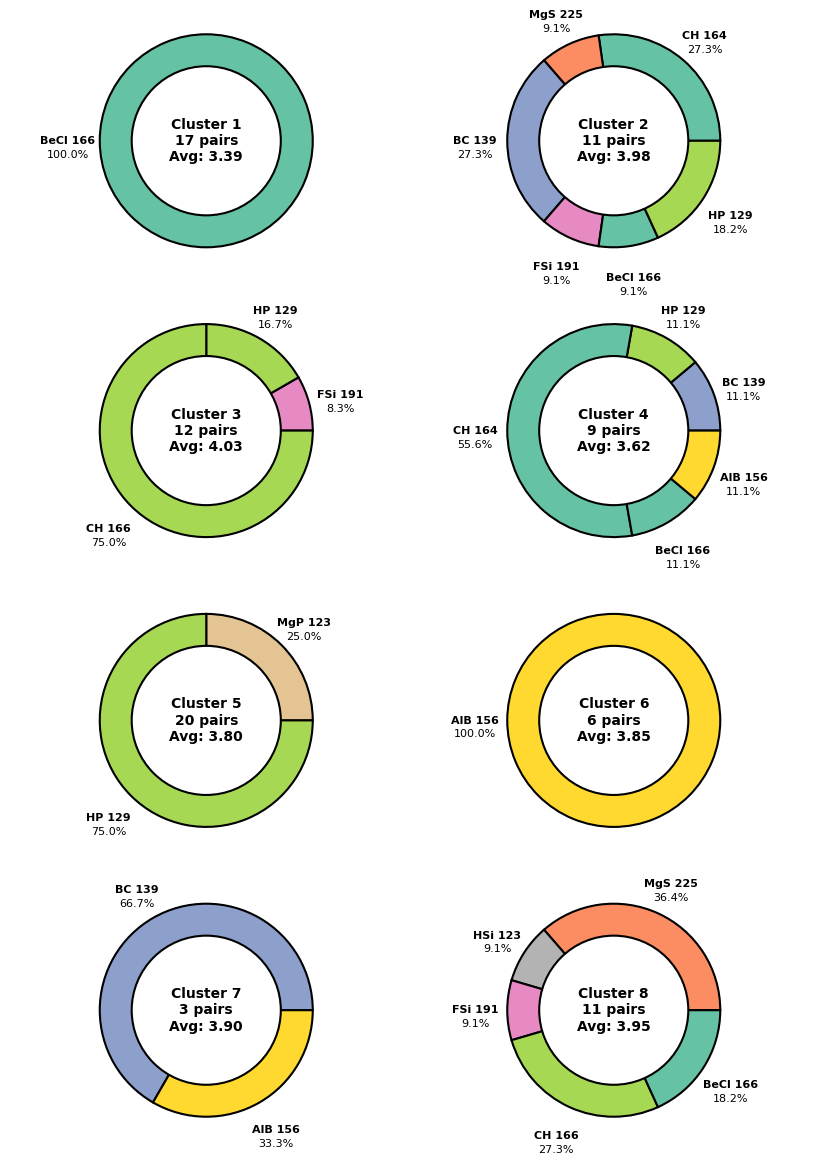

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Configura il layout per una pagina A4 in orizzontale
fig, axes = plt.subplots(4, 2, figsize=(8.3, 11.7))  # 4 righe, 2 colonne
axes = axes.flatten()  # Converti in un array monodimensionale per iterare facilmente

# Itera attraverso i grafici e le assi
for idx_cluster, (histcluster, ax) in enumerate(zip(hist.values(), axes)):
    title_text = f'Cluster {idx_cluster+1}\n{len_cluster[idx_cluster]} pairs\nAvg: {cluster_distances[idx_cluster+1]:.2f}'

    labels = list(histcluster.keys())
    values = list(histcluster.values())
    colors = [colormap[f'{i}'] for i in labels]
    labels = [f'{x.split("_")[0]} {x.split("_")[1]}' for x in labels]

    # Disegna il donut chart senza percentuali
    wedges, texts = ax.pie(
        values, labels=None, colors=colors,  # Disabilita i label automatici
        wedgeprops=dict(edgecolor='black', linewidth=1.5), startangle=0
    )

    # Aggiungi il buco al centro con il bordo nero
    centre_circle = plt.Circle((0, 0), 0.70, fc='white', edgecolor='black', linewidth=1.5)
    ax.add_artist(centre_circle)

    # Aggiungi il titolo al centro del buco
    ax.text(
        0, 0, title_text, ha='center', va='center', fontsize=10,
        fontweight='bold', color='black'
    )

    # Aggiungi manualmente label e percentuali centrati
    for wedge, value, label in zip(wedges, values, labels):
        # Calcola l'angolo medio della fetta
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.radians(angle)) * 1.3  # Posizione leggermente fuori dalla fetta
        y = np.sin(np.radians(angle)) * 1.3

        # Posiziona il label
        ax.text(
            x, y, label, ha='center', va='center', fontsize=8,
            fontweight='bold', color='black'
        )

        # Posiziona la percentuale sotto il label
        percentage = f"{value * 100:.1f}%"
        ax.text(
            x, y - 0.13, percentage, ha='center', va='center', fontsize=8,
            color='black'
        )

    ax.axis('equal')  # Mantieni l'aspetto circolare

# Rimuovi assi inutilizzati (se ci sono meno grafici degli spazi disponibili)
for ax in axes[len(hist):]:
    ax.axis('off')

# Regola il layout per evitare sovrapposizioni
plt.tight_layout()

# Salva o mostra l'immagine finale
plt.savefig("PieCharts.png", dpi=300, bbox_inches='tight')  # Salva il file
plt.show()
